### Project 2 - UTA

Sebastian Chwilczynski - 148248
Karol Cyganik - 148250

We use the same dataset as in the previous project, namely *perspektywy universities ranking*

In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv("../universities_final.csv", index_col="id")
data

,WSK_ocena_p._kadre,ekonom._losy_absolw.,jak._przyj._na_studia,TOP_10,pub._we_wspl._zagr.,distance,progi
id,,,,,,,
B,34.0,78.2,78.2,63.8,51.0,309,0.783500
C,0.8,50.8,56.1,44.7,43.7,132,0.700000
D,3.0,64.7,74.1,7.1,53.6,188,0.700000
E,1.7,74.6,63.2,8.5,17.6,188,0.680000
H,6.5,51.3,61.6,55.3,29.4,375,0.330000
I,22.6,84.9,90.4,46.8,66.2,413,0.785000
J,4.8,72.4,73.6,52.5,58.2,166,0.780000
K,0.7,53.8,55.5,44.7,63.5,373,0.600000
L,7.8,42.3,46.7,100.0,77.2,56,0.625000


In [2]:
from mcda.uta import PreferenceType, UTAInconsistency, OrdinalRegression, RelationUTA

preference_types = [PreferenceType.GAIN] * 5 + [PreferenceType.COST] * 2
pd.DataFrame(np.array([preference_types]), columns=data.columns)

,WSK_ocena_p._kadre,ekonom._losy_absolw.,jak._przyj._na_studia,TOP_10,pub._we_wspl._zagr.,distance,progi
0,PreferenceType.GAIN,PreferenceType.GAIN,PreferenceType.GAIN,PreferenceType.GAIN,PreferenceType.GAIN,PreferenceType.COST,PreferenceType.COST


Our Implementation support custom number of breaks for every attribute but by default we set that every marginal utility function will have 1 break

In [3]:
num_breaks = [1] * 7

Our implementation excpects Preference information to be in numeric form so we instantiate mapping from letter to number

In [4]:
from enum import Enum
class ClassNames(Enum):
    B = 0
    C = 1
    D = 2
    E = 3
    H = 4
    I = 5
    J = 6
    K = 7
    L = 8
    M = 9
    N = 10
    P = 11
    Q = 12
    R = 13
    T = 14
    U = 15
    V = 16
    W = 17
    Y = 18
    Z = 19
    def __int__(self):
        return self.value

We created preferences using assignments from previous project:
* Class 1 -> D
* Class 2 -> U
* Class 3 -> B
* Class 4 -> I

Actually this was very hard to create situation that solver was forced to use this positive and negative errors, having as many attributes and one breakpoint on each side this is very flexible. So eventually we ended up with adding more preference information that we wanted but eventually some inconsistency was introduced


In [5]:
pref_informations = [
    (ClassNames.I, ClassNames.U, RelationUTA.PREFFERENCE),
    (ClassNames.I, ClassNames.D, RelationUTA.PREFFERENCE),
    (ClassNames.I, ClassNames.B, RelationUTA.PREFFERENCE),
    (ClassNames.B, ClassNames.U, RelationUTA.PREFFERENCE),
    (ClassNames.B, ClassNames.D, RelationUTA.PREFFERENCE),
    (ClassNames.I, ClassNames.M, RelationUTA.PREFFERENCE),
    (ClassNames.B, ClassNames.M, RelationUTA.PREFFERENCE),
    (ClassNames.Y, ClassNames.B, RelationUTA.INDIFFERENCE),
    #! Things below were added artificially to make solver use under/over estimates
    (ClassNames.W, ClassNames.B, RelationUTA.INDIFFERENCE),
    (ClassNames.W, ClassNames.C, RelationUTA.INDIFFERENCE),
    (ClassNames.W, ClassNames.L, RelationUTA.INDIFFERENCE),
    (ClassNames.W, ClassNames.N, RelationUTA.INDIFFERENCE),
    (ClassNames.W, ClassNames.P, RelationUTA.INDIFFERENCE),
    ]

At first we tried ordinal Regression, and it is off by 0.15 in total

In [6]:
uta = OrdinalRegression(data.to_numpy(), pref_informations,
                              preference_types, num_breaks, list(data.columns))
outcome = uta.solve()

outcome['status'], outcome['error']

('Optimal', 0.155401417)

Then we run Inconsistency solver and it turns out that one needs to remove at least 2 comaprisons to make preference information consistent 

In [7]:
inconsistent =  UTAInconsistency(data.to_numpy(), pref_informations,
                              preference_types, num_breaks, list(data.columns))

outcome = inconsistent.solve()
outcome['status'], outcome['error']

('Optimal', 2.0)

Let's find all sets of alternatives that can be removed to resolve inconsistency

In [8]:
all_inconsistent = inconsistent.find_all_inconsistent()

for inconsistent in all_inconsistent:
    print(" ".join(inconsistent))
    print("===========================")

v_ClassNames.W_ClassNames.L v_ClassNames.W_ClassNames.P
v_ClassNames.W_ClassNames.B v_ClassNames.W_ClassNames.C v_ClassNames.Y_ClassNames.B
v_ClassNames.W_ClassNames.C v_ClassNames.W_ClassNames.L v_ClassNames.Y_ClassNames.B
v_ClassNames.W_ClassNames.C v_ClassNames.W_ClassNames.N v_ClassNames.Y_ClassNames.B
v_ClassNames.B_ClassNames.M v_ClassNames.W_ClassNames.C v_ClassNames.W_ClassNames.N
v_ClassNames.B_ClassNames.M v_ClassNames.W_ClassNames.C v_ClassNames.W_ClassNames.L
v_ClassNames.W_ClassNames.C v_ClassNames.W_ClassNames.N v_ClassNames.W_ClassNames.P
v_ClassNames.B_ClassNames.D v_ClassNames.W_ClassNames.C v_ClassNames.W_ClassNames.P
v_ClassNames.B_ClassNames.U v_ClassNames.W_ClassNames.C v_ClassNames.W_ClassNames.L
v_ClassNames.W_ClassNames.C v_ClassNames.W_ClassNames.P v_ClassNames.Y_ClassNames.B
v_ClassNames.W_ClassNames.B v_ClassNames.W_ClassNames.N v_ClassNames.W_ClassNames.P
v_ClassNames.B_ClassNames.M v_ClassNames.W_ClassNames.B v_ClassNames.W_ClassNames.C
v_ClassNames.W_Class

There are quite many of those. However, it seems the most reasonable to remove as little as possible so we remove 
W `I` L and W `I` P

In [9]:
pref_informations = [
    (ClassNames.I, ClassNames.U, RelationUTA.PREFFERENCE),
    (ClassNames.I, ClassNames.D, RelationUTA.PREFFERENCE),
    (ClassNames.I, ClassNames.B, RelationUTA.PREFFERENCE),
    (ClassNames.B, ClassNames.U, RelationUTA.PREFFERENCE),
    (ClassNames.B, ClassNames.D, RelationUTA.PREFFERENCE),
    (ClassNames.I, ClassNames.M, RelationUTA.PREFFERENCE),
    (ClassNames.B, ClassNames.M, RelationUTA.PREFFERENCE),
    (ClassNames.Y, ClassNames.B, RelationUTA.INDIFFERENCE),
    #! Things below were added artificially to make solver use under/over estimates
    (ClassNames.W, ClassNames.B, RelationUTA.INDIFFERENCE),
    (ClassNames.W, ClassNames.C, RelationUTA.INDIFFERENCE),
    #(ClassNames.W, ClassNames.L, RelationUTA.INDIFFERENCE),
    (ClassNames.W, ClassNames.N, RelationUTA.INDIFFERENCE),
    #(ClassNames.W, ClassNames.P, RelationUTA.INDIFFERENCE),
    ]

Now we run solver in verbose mode so that you can see:
* all of the equations
* variable's values
* optimal objective value

In [10]:
inconsistent =  UTAInconsistency(data.to_numpy(), pref_informations,
                              preference_types, num_breaks, list(data.columns))

outcome = inconsistent.solve(verbose=True)

PROBLEM DEFINITION
UTA:
MINIMIZE
1*v_ClassNames.B_ClassNames.D + 1*v_ClassNames.B_ClassNames.M + 1*v_ClassNames.B_ClassNames.U + 1*v_ClassNames.I_ClassNames.B + 1*v_ClassNames.I_ClassNames.D + 1*v_ClassNames.I_ClassNames.M + 1*v_ClassNames.I_ClassNames.U + 1*v_ClassNames.W_ClassNames.B + 1*v_ClassNames.W_ClassNames.C + 1*v_ClassNames.W_ClassNames.N + 1*v_ClassNames.Y_ClassNames.B + 0
SUBJECT TO
_C1: - 0.418 U_0(0.0) + 0.418 U_0(50.0) + 0.476603119584 U_1(100.0)
 - 0.521663778163 U_1(42.3) + 0.0450606585789 U_1(71.15)
 + 0.639774859287 U_2(100.0) - 0.696060037523 U_2(46.7)
 + 0.0562851782364 U_2(73.35) + 0.426264800861 U_3(53.550000000000004)
 - 0.426264800861 U_3(7.1) + 0.179611650485 U_4(100.0)
 - 0.808252427184 U_4(17.6) + 0.628640776699 U_4(58.800000000000004)
 + 0.637404580153 U_5(318.0) - 0.637404580153 U_5(580.0)
 - 0.81308411215 U_6(0.33) + 0.395638629283 U_6(0.651)
 + 0.417445482866 U_6(0.972) + v_ClassNames.I_ClassNames.U >= 1e-05

_C2: - 0.392 U_0(0.0) + 0.392 U_0(50.0) + 0.4

Now we plot marginal utility functions

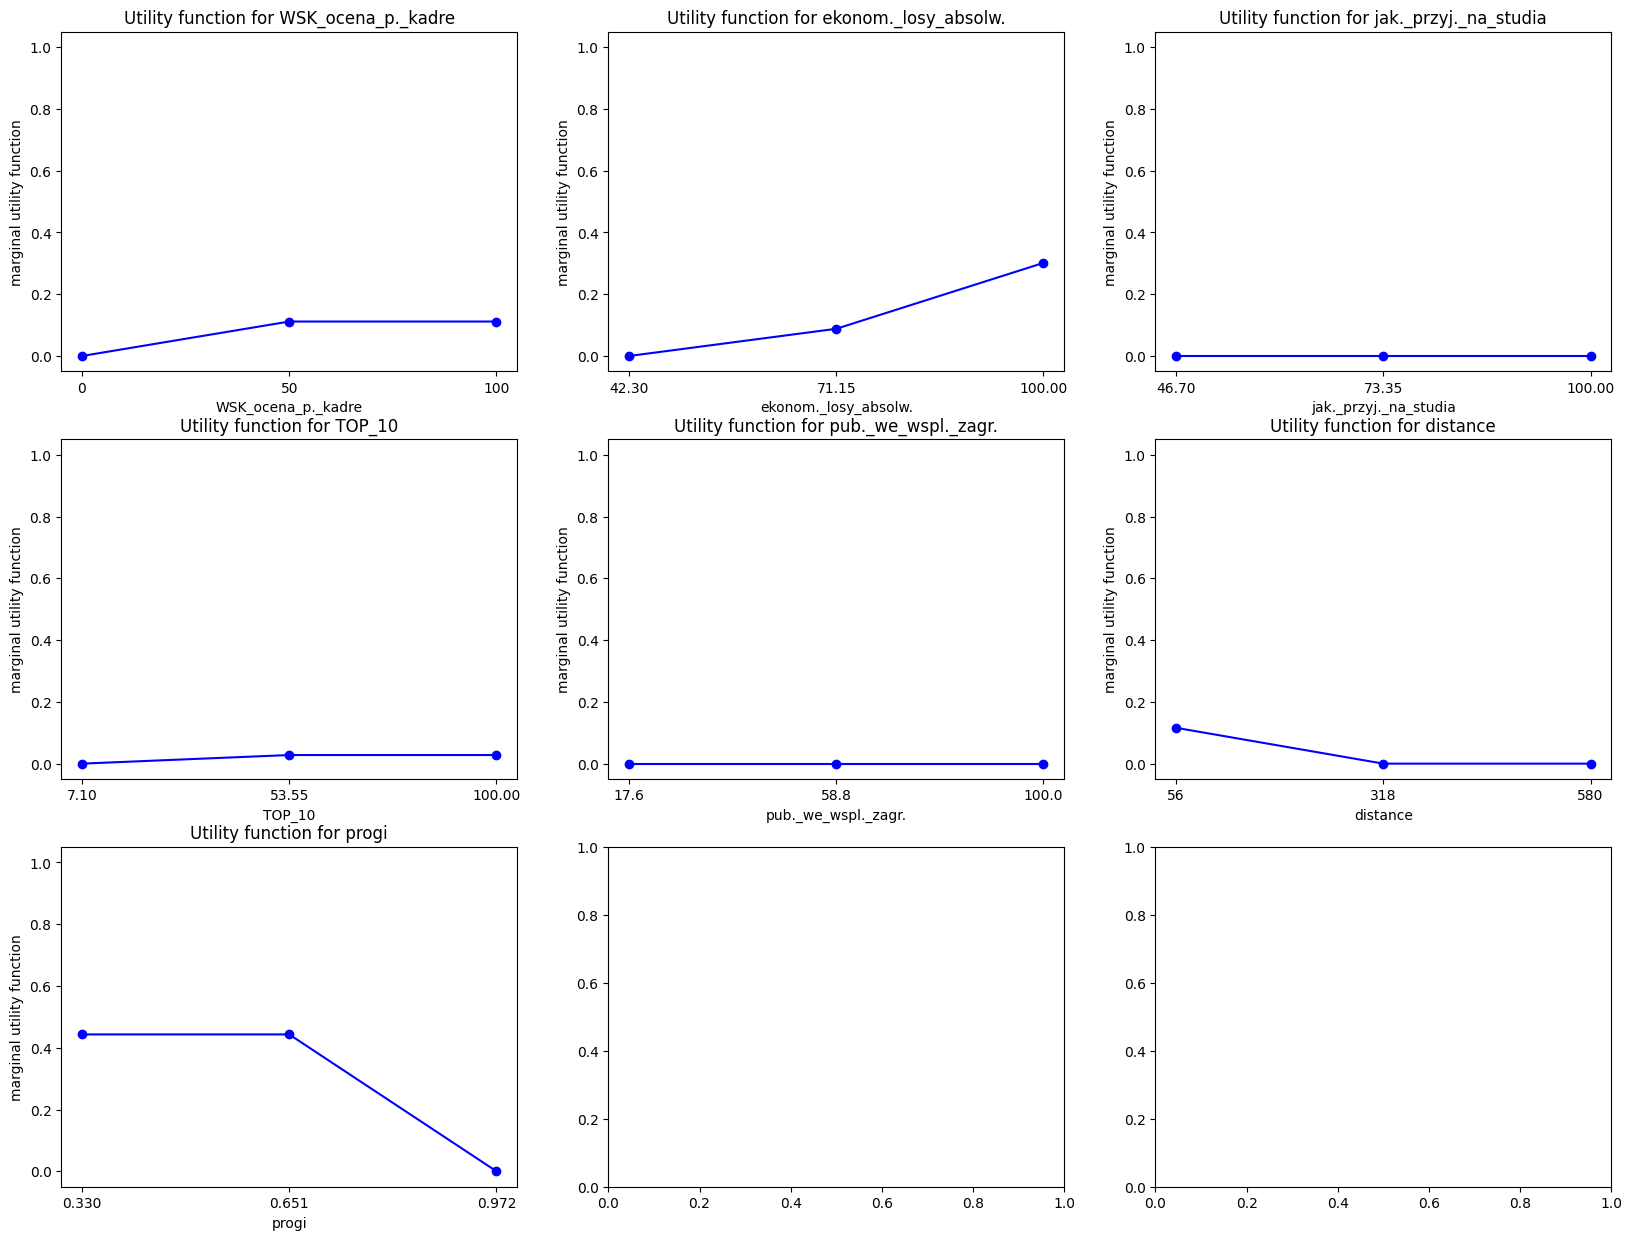

In [11]:
inconsistent.plot_utility_functions()

Results as not that satisfactory. We see few drawbacks of this method:
* If we use marginal utility functions with at least one break, solver becomes very flexible and can tune itself very easily to values that we won't normally assing and consider
* with this implementation we can't choose exact values of utility function at breakpoints. Probably this is possible to return acceptable intervals of every break. But for now we must accept what solver returns.
* Simplex method is kind of greedy it can't take information that we prefer more balanced utility functions. If it's enough it will just use one.

Big advantages:
* DM doesn't have to provide hyperparameters to us.
* We may find inconsistencies in our Ground truth.
* We may easily verify if all attributes are really needed. Here we can see that we don't need all to reproduce preference information.

Let's finish with creating ranking based on our solution.

In [12]:
data['scores'] = inconsistent.evaluate(data.to_numpy())
data = data.sort_values("scores", ascending=False)
data

,WSK_ocena_p._kadre,ekonom._losy_absolw.,jak._przyj._na_studia,TOP_10,pub._we_wspl._zagr.,distance,progi,scores
id,,,,,,,,
Z,33.1,74.5,59.9,59.6,47.7,188,0.400000,0.715258
P,1.2,84.4,72.8,64.5,46.6,98,0.700000,0.689498
Q,16.6,63.7,69.9,42.6,39.8,147,0.650000,0.642511
L,7.8,42.3,46.7,100.0,77.2,56,0.625000,0.604415
E,1.7,74.6,63.2,8.5,17.6,188,0.680000,0.578881
R,0.0,72.3,51.8,39.7,66.2,299,0.350000,0.567687
I,22.6,84.9,90.4,46.8,66.2,413,0.785000,0.522152
H,6.5,51.3,61.6,55.3,29.4,375,0.330000,0.512996
Y,74.5,100.0,89.4,62.4,49.2,166,0.972000,0.508138


and compare it with promethee2 ranking

In [13]:
rank_uta = list(data.index)
print(rank_uta)
rank_promethee2 = ['Y','L','M','N','Z','B','Q','I','T','J','P','H','R','C','K','V','W','D','E','U']

['Z', 'P', 'Q', 'L', 'E', 'R', 'I', 'H', 'Y', 'N', 'C', 'B', 'W', 'D', 'K', 'U', 'M', 'V', 'J', 'T']


Inspecting outcomes visually these ranking are very different. The reason is that we are quite poor Decision Makers and probably both preference information and hyperparameters provided to PROMETHEE 2 were contradicting each other. During these 2 project the most challenging part was not the coding but figuring out appropriate preference information and hyperparameters. Being a decision maker is not easy at all.

For promethee alternative Y was the best one and it is somewhere in the middle for the UTA this is not good information. This is because UTA solver utilized `PROGI` attribute ang gave it the biggest importance. For promethee 2 we considered `PROGI` as the least important. This is probably the biggest issue here that we can't emphasis which attributes are more important for us.

Moreover two attributes that we considered to be very imporant namely `Top_10` and `pub_we_wspol_z_zagranica` are not utilized by UTA at all! It is just not necessary to use them to reproduce preference information. This may be a sign for the DM that this information is not of high quality. From this perspective we prefer PROMETHEE II ranking.

Finally Kendall's Tau

In [16]:
mapping = {data.name: data.value for data in ClassNames}

In [17]:
from mcda.utils import kendalls_tau

kendalls_tau([mapping[x] for x in rank_uta], [mapping[x] for x in rank_promethee2])

0.18947368421052635

quote from lectures: *In practice, one often accepts the resulting ranking with Kendall’s τ at least 0.75*. So this rankings differ by much. However, at least are not completely opposite :)